In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error as mape

from itertools import product
from tqdm import tqdm_notebook
from typing import Union

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

# Replace with the path to the CSV file
df = pd.read_csv("C:\\Users\\e410675\\OneDrive - London South Bank University\\LSBU - Jose's Collaborative Projects\\Norfolk and Waveney Demand Modelling\\New Data\\Data and scripts\\Bed_Availability_and_Occupancy_2000-2025_combined_data_csv_format.csv")

In [3]:
df

,Date,Org_Code,Org_Name,Sector,Number_Of_Beds_available,Number_Of_Beds_occupied
0,30/06/2010,RCX,"The Queen Elizabeth Hospital, King's Lynn, NHS...",General & Acute,431.604396,337.868132
1,30/06/2010,RGQ,Ipswich Hospital NHS Trust,Maternity,44,22.879121
2,30/06/2010,RGR,West Suffolk NHS Foundation Trust,Maternity,47,15.164835
3,30/06/2010,RGT,Cambridge University Hospitals NHS Foundation ...,Maternity,42,26.494505
4,30/06/2010,RM1,Norfolk And Norwich University Hospitals NHS F...,Maternity,46.78022,26
...,...,...,...,...,...,...
56523,31/12/2023,RVR,Epsom And St Helier University Hospitals NHS T...,Mental Illness,0,0
56524,31/12/2023,RV3,Central And North West London NHS Foundation T...,Mental Illness,605.869565,558.826087
56525,31/12/2023,RRV,University College London Hospitals NHS Founda...,Mental Illness,10.228261,5.315217
56526,31/12/2023,RQY,South West London And St George's Mental Healt...,Mental Illness,344.51087,307.206522


# Visualization

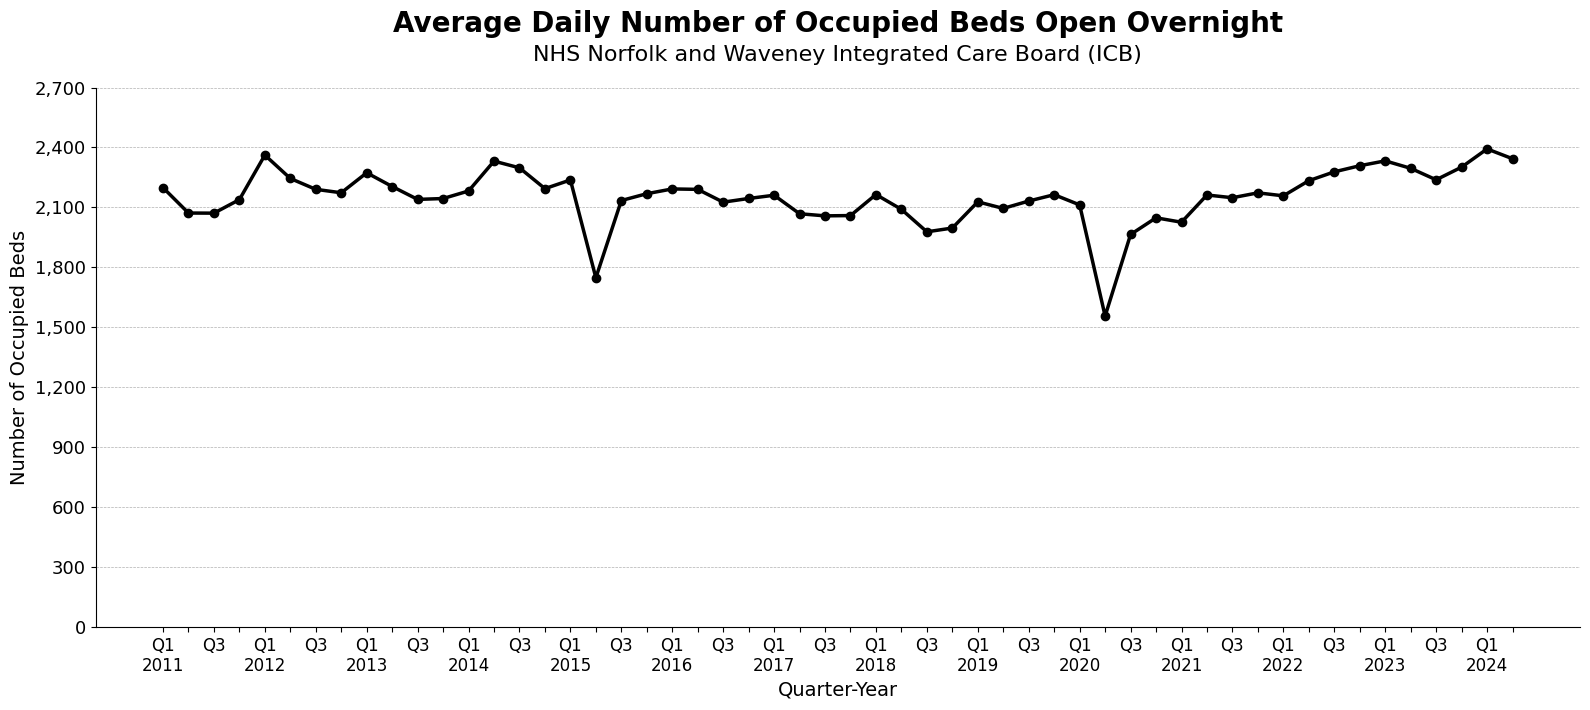

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# === Create df_plot from df ===
df_plot = df.copy()

# === Clean and preprocess ===
df_plot['Date'] = pd.to_datetime(df_plot['Date'], dayfirst=True, errors='coerce')
df_plot['Number_Of_Beds_available'] = pd.to_numeric(df_plot['Number_Of_Beds_available'], errors='coerce')
df_plot['Number_Of_Beds_occupied'] = pd.to_numeric(df_plot['Number_Of_Beds_occupied'], errors='coerce')
df_plot['Sector'] = df_plot['Sector'].str.strip().str.title()
df_plot['Quarter'] = df_plot['Date'].dt.to_period('Q')

# === Filter for Norfolk & Waveney ICB organizations ===
norfolk_orgs = [
    "James Paget University Hospitals NHS Foundation Trust",
    "Norfolk And Norwich University Hospitals NHS Foundation Trust",
    "Norfolk And Suffolk NHS Foundation Trust",
    "Norfolk Community Health And Care NHS Trust",
    "The Queen Elizabeth Hospital, King's Lynn, NHS Foundation Trust"
]
df_icb = df_plot[df_plot['Org_Name'].isin(norfolk_orgs)].copy()

# === Group by Quarter and sum Number_Of_Beds_occupied ===
df_grouped = (
    df_icb[df_icb['Quarter'] >= '2011Q1']
    .groupby('Quarter')['Number_Of_Beds_occupied']
    .sum()
)

# === Format x-axis labels ===
def format_labels(quarters):
    return [f"Q{q.quarter}\n{q.year}" if q.quarter == 1 else ("Q3" if q.quarter == 3 else "") for q in quarters]

x_labels = format_labels(df_grouped.index)

# === Plot ===
fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('white')

ax.plot(
    range(len(df_grouped)),
    df_grouped.values,
    marker='o', linestyle='-', linewidth=2.5, color='black'
)

# === Titles and labels ===
ax.set_title("Average Daily Number of Occupied Beds Open Overnight",
             fontsize=20, pad=40, weight='bold')
ax.text(0.5, 1.05, "NHS Norfolk and Waveney Integrated Care Board (ICB)", fontsize=16, ha='center', transform=ax.transAxes)
ax.set_ylabel("Number of Occupied Beds", fontsize=14)
ax.set_xlabel("Quarter-Year", fontsize=14)

# === Axis formatting (y-axis 0 to 2700) ===
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=0, ha='center', fontsize=12)
ax.set_ylim(0, 2700)
ax.yaxis.set_major_locator(ticker.MultipleLocator(300))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.tick_params(axis='y', labelsize=13)

# === Style ===
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)

# === Save Plot ===
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [5]:
# === Group by Quarter and calculate sum and representative date ===
df_temp = df_icb[df_icb['Quarter'] >= '2011Q1'].copy()

# Get sum of beds and representative date (e.g., first date in quarter)
df_grouped = (
    df_temp.groupby('Quarter').agg({
        'Number_Of_Beds_occupied': 'sum',
        'Date': 'min'  # You could also use 'max' or 'mean'
    }).reset_index()
)

# Rename columns for clarity (optional)
df_grouped.rename(columns={'Date': 'Representative_Date'}, inplace=True)


df = df_grouped[['Representative_Date', 'Number_Of_Beds_occupied']]

df.columns = ['date', 'y']

In [6]:
df.head()

,date,y
0,2011-03-31,2199.100000
1,2011-06-30,2071.868131
2,2011-09-30,2071.260870
3,2011-12-31,2138.945652
4,2012-03-31,2361.945055


In [7]:
# Add new forecast rows
df = pd.concat([
    df,
    pd.DataFrame({
        'date': pd.to_datetime(['2024-09-30', '2024-12-31', '2025-03-31']),
        'y': [2238.543478, 2283.717391, 2312.004518]
    })
]).sort_values('date').reset_index(drop=True)

In [8]:
df.head()

,date,y
0,2011-03-31,2199.100000
1,2011-06-30,2071.868131
2,2011-09-30,2071.260870
3,2011-12-31,2138.945652
4,2012-03-31,2361.945055


# Exploration

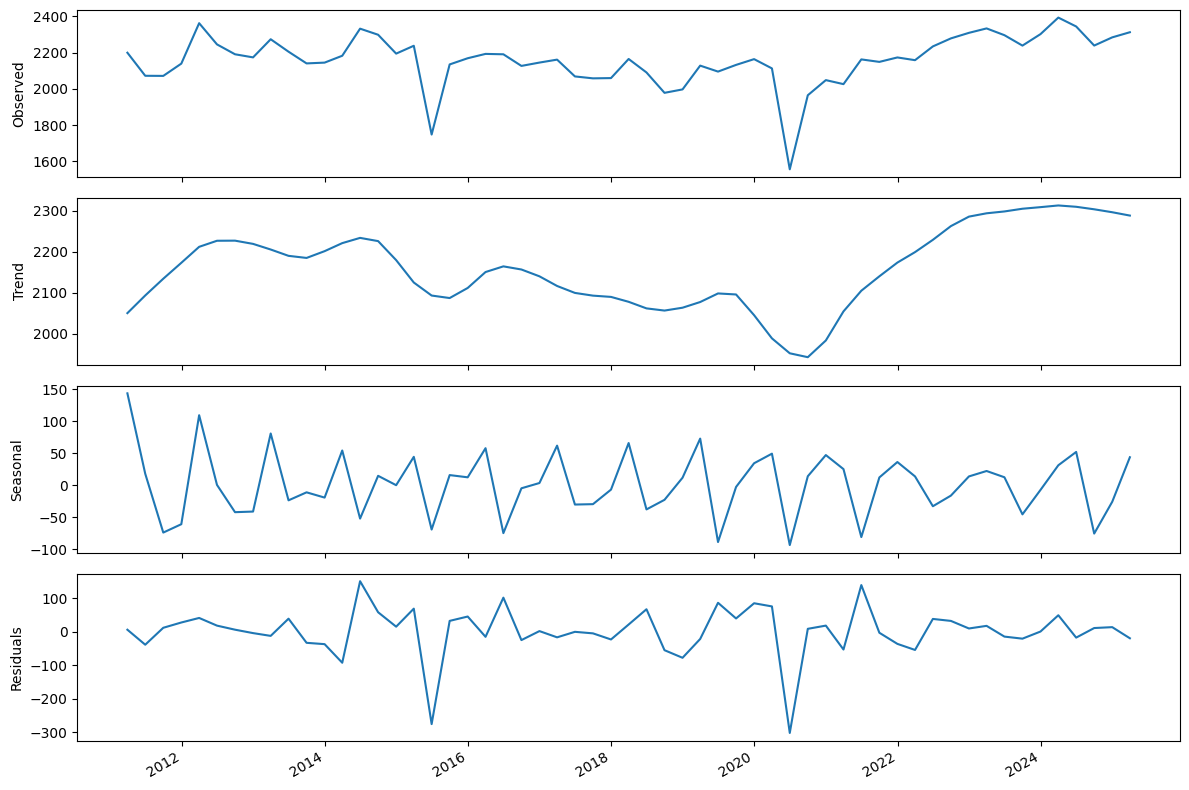

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# STL decomposition (still applied to the 'y' values)
decomposition = STL(df['y'], period=4).fit()

# Plot using 'date' as x-axis manually
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 8))

ax1.plot(df['date'], decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(df['date'], decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(df['date'], decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(df['date'], decomposition.resid)
ax4.set_ylabel('Residuals')

# Automatically format x-axis with date labels
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# Modeling

In [10]:
# === ADF Test ===
adf_result = adfuller(df['y'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF Statistic: -4.3229
p-value: 0.0004


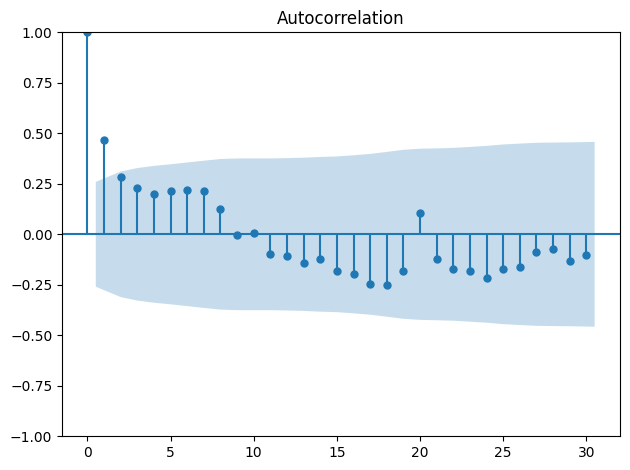

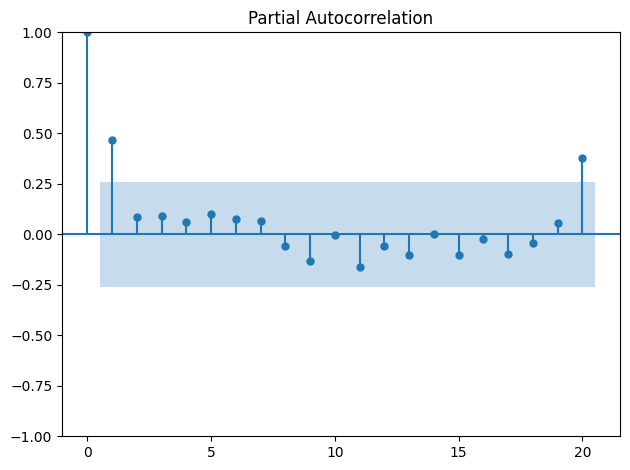

In [11]:
# === ACF/PACF ===
plot_acf(df['y'], lags=30); plt.tight_layout(); plt.show()
plot_pacf(df['y'], lags=20); plt.tight_layout(); plt.show()

# Train/test split

In [12]:
# === Split Data ===
train_full = df[:-4].copy()
test = df[-4:].copy()

In [13]:
# Further split train into train_short and val
val_size = 4
train_short = train_full[:-val_size]
val = train_full[-val_size:]

# SARIMA

In [14]:
def cross_validated_SARIMA_MAPE(df, order_list, d, D, s, n_val=8, n_splits=3, step=1):
    """
    Perform rolling-origin cross-validation for SARIMA tuning.
    
    Parameters:
        df (pd.DataFrame): Full time series with columns ['date', 'y']
        order_list (list): List of (p, q, P, Q) tuples to evaluate
        d, D, s (int): SARIMA differencing and seasonal params
        n_val (int): Forecast horizon per split (e.g. 8 quarters)
        n_splits (int): Number of rolling CV windows
        step (int): How much to shift the window forward per split
    
    Returns:
        DataFrame with average MAPE per model
    """
    results = []

    for order in tqdm_notebook(order_list):
        mape_scores = []

        for split in range(n_splits):
            train_end = -((n_val + step * (n_splits - split - 1)))
            train_end = None if train_end == 0 else train_end

            train = df.iloc[:train_end - n_val]
            val = df.iloc[train_end - n_val:train_end]

            try:
                model = SARIMAX(
                    train['y'],
                    order=(order[0], d, order[1]),
                    seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False
                ).fit(disp=False)

                pred = model.get_forecast(steps=n_val).predicted_mean
                score = mape(val['y'], pred)
                mape_scores.append(score)

            except:
                mape_scores.append(np.inf)  # penalize failures

        avg_mape = np.mean(mape_scores)
        results.append([order, avg_mape])

    return pd.DataFrame(results, columns=['(p,q,P,Q)', 'Avg_MAPE']).sort_values(by='Avg_MAPE').reset_index(drop=True)


In [15]:
# Define your grid
ps = range(0, 3)
qs = range(0, 3)
Ps = range(0, 2)
Qs = range(0, 2)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))

# Run cross-validated optimization
cv_results = cross_validated_SARIMA_MAPE(
    df=train_full[['date', 'y']],
    order_list=SARIMA_order_list,
    d=1, D=1, s=4,
    n_val=4,
    n_splits=3,
    step=2  # how far each CV window jumps forward
)

print("Best SARIMA models (by Avg MAPE):")
print(cv_results.head())



  0%|          | 0/625 [00:00<?, ?it/s]

Best SARIMA models (by Avg MAPE):
      (p,q,P,Q)  Avg_MAPE
0  (2, 2, 4, 1)  0.054346
1  (0, 0, 4, 3)  0.056542
2  (3, 3, 0, 0)  0.061964
3  (0, 0, 4, 2)  0.062159
4  (0, 4, 0, 0)  0.062698


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   53
Model:             SARIMAX(2, 1, 2)x(4, 1, [1], 4)   Log Likelihood                -289.069
Date:                             Fri, 04 Jul 2025   AIC                            598.138
Time:                                     15:37:36   BIC                            616.850
Sample:                                          0   HQIC                           605.209
                                              - 53                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9755      0.277      7.134      0.000       1.433       2.518
ar.L2         -0.9775      

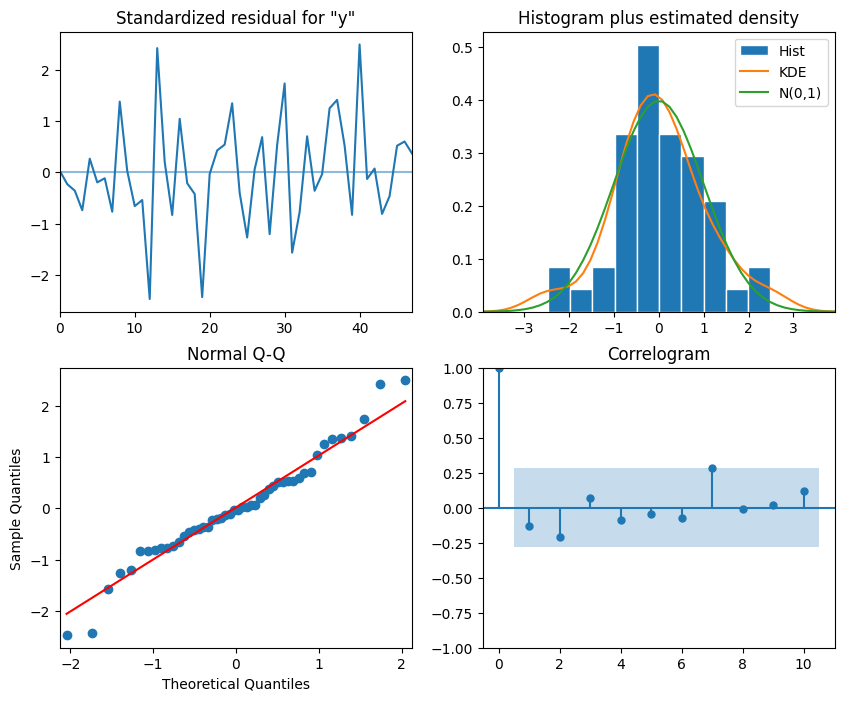

In [16]:
d = 1      # or whatever value you used during tuning
D = 1
s = 4      # quarterly seasonality


# === Fit best model on full train set ===
best_order = cv_results.iloc[0]['(p,q,P,Q)']  # now using CV results

SARIMA_model = SARIMAX(
    train_full['y'],
    order=(best_order[0], d, best_order[1]),
    seasonal_order=(best_order[2], D, best_order[3], s),
    simple_differencing=False
)

SARIMA_model_fit = SARIMA_model.fit(disp=False)

# === Summary and diagnostics ===
print(SARIMA_model_fit.summary())
SARIMA_model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()


In [27]:
SARIMA_model = SARIMAX(train_full['y'], order=(2,d,1), seasonal_order=(0,D,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   53
Model:             SARIMAX(2, 1, 2)x(4, 1, [1], 4)   Log Likelihood                -289.069
Date:                             Fri, 04 Jul 2025   AIC                            598.138
Time:                                     15:39:21   BIC                            616.850
Sample:                                          0   HQIC                           605.209
                                              - 53                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9755      0.277      7.134      0.000       1.433       2.518
ar.L2         -0.9775      

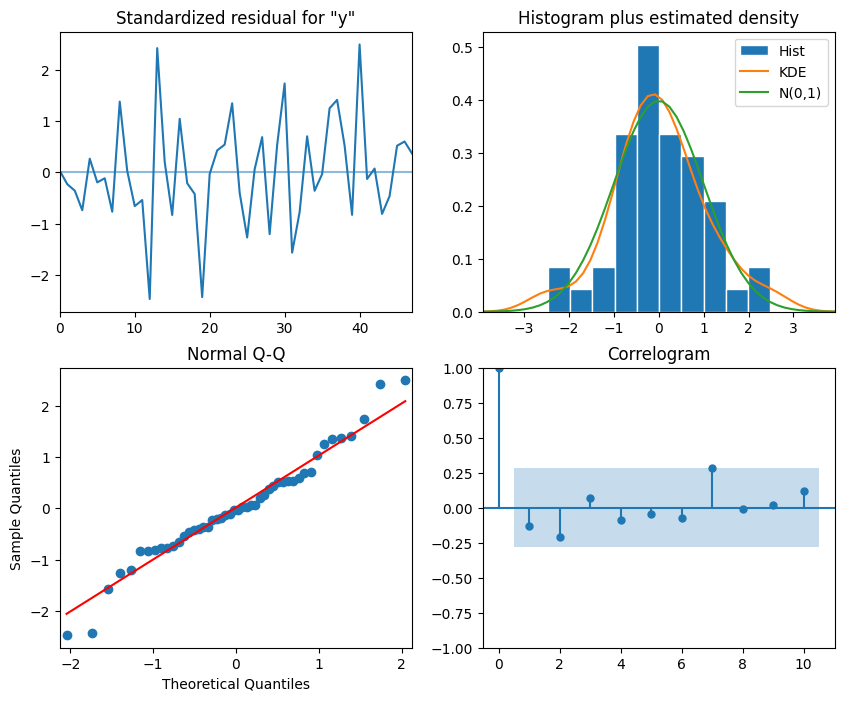

In [28]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

residuals = SARIMA_model_fit.resid

# Run Ljung-Box test for lags 1 to 10
ljung_box_result = acorr_ljungbox(residuals, lags=np.arange(1, 11), return_df=True)

# Print nicely
print(ljung_box_result)

# Optional: interpret results
for lag, p in zip(ljung_box_result.index, ljung_box_result['lb_pvalue']):
    if p < 0.05:
        print(f"❌ Residuals are NOT white noise at lag {lag} (p = {p:.3f})")
    else:
        print(f"✅ Residuals look like white noise at lag {lag} (p = {p:.3f})")

     lb_stat  lb_pvalue
1   0.324030   0.569196
2   0.329548   0.848085
3   0.532330   0.911733
4   5.499364   0.239785
5   5.511324   0.356706
6   5.565355   0.473593
7   5.568926   0.590884
8   5.640129   0.687470
9   5.640130   0.775325
10  5.644117   0.844225
✅ Residuals look like white noise at lag 1 (p = 0.569)
✅ Residuals look like white noise at lag 2 (p = 0.848)
✅ Residuals look like white noise at lag 3 (p = 0.912)
✅ Residuals look like white noise at lag 4 (p = 0.240)
✅ Residuals look like white noise at lag 5 (p = 0.357)
✅ Residuals look like white noise at lag 6 (p = 0.474)
✅ Residuals look like white noise at lag 7 (p = 0.591)
✅ Residuals look like white noise at lag 8 (p = 0.687)
✅ Residuals look like white noise at lag 9 (p = 0.775)
✅ Residuals look like white noise at lag 10 (p = 0.844)


# Forecasting

In [36]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,1), seasonal_order=(0,1,1,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [37]:
pred_df = test.copy()

pred_df

,date,y,last_season,SARIMA_pred
53,2024-06-30,2343.736263,2295.758242,2261.348862
54,2024-09-30,2238.543478,2238.271739,2395.903071
55,2024-12-31,2283.717391,2301.554349,2452.438348
56,2025-03-31,2312.004518,2392.769231,2396.218136


In [38]:
TRAIN_LEN = len(train_full)
HORIZON = len(test)
WINDOW = 4

test['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

test

,date,y,last_season,SARIMA_pred
53,2024-06-30,2343.736263,2295.758242,2261.348862
54,2024-09-30,2238.543478,2238.271739,2395.903071
55,2024-12-31,2283.717391,2301.554349,2452.438348
56,2025-03-31,2312.004518,2392.769231,2396.218136


In [39]:
test['SARIMA_pred'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

test

,date,y,last_season,SARIMA_pred
53,2024-06-30,2343.736263,2295.758242,2268.916145
54,2024-09-30,2238.543478,2238.271739,2294.907318
55,2024-12-31,2283.717391,2301.554349,2314.000656
56,2025-03-31,2312.004518,2392.769231,2371.279745


# Evaluate

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# === Prepare actuals and predictions ===
y_true = test['y']
y_pred = test['SARIMA_pred']
last_train_value = train_full['y'].iloc[-1]
baseline_pred = np.full_like(y_true, fill_value=last_train_value)

# === When interpretability is key ===
mae_model = mean_absolute_error(y_true, y_pred)                      # Mean Absolute Error
rmse_model = mean_squared_error(y_true, y_pred, squared=False)       # Root Mean Squared Error

mae_baseline = mean_absolute_error(y_true, baseline_pred)
rmse_baseline = mean_squared_error(y_true, baseline_pred, squared=False)

# === When comparing across series ===
mape_model = mean_absolute_percentage_error(y_true, y_pred)          # MAPE
mape_baseline = mean_absolute_percentage_error(y_true, baseline_pred)

# sMAPE: Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_model = smape(y_true, y_pred)
smape_baseline = smape(y_true, baseline_pred)

# MASE: Mean Absolute Scaled Error
def mase(y_true, y_pred, y_train):
    naive_error = np.abs(np.diff(y_train)).mean()
    return np.mean(np.abs(y_true - y_pred)) / naive_error

mase_model = mase(y_true, y_pred, train_full['y'])
mase_baseline = mase(y_true, baseline_pred, train_full['y'])

# === When assessing model bias ===
bias_model = np.mean(y_pred - y_true)                                # Forecast Bias
bias_baseline = np.mean(baseline_pred - y_true)

# === Print all metrics with notes ===
print("=== Model Performance (SARIMA) ===")
print(f"MAE: {mae_model:.4f}                # Good for interpretability")
print(f"RMSE: {rmse_model:.4f}              # Penalizes larger errors")
print(f"MAPE: {mape_model * 100:.2f}%       # Percentage-based, easy to compare")
print(f"sMAPE: {smape_model:.2f}%           # More stable than MAPE on low values")
print(f"MASE: {mase_model:.4f}              # Scale-independent, good across series")
print(f"Forecast Bias: {bias_model:.4f}     # Positive = overestimate, Negative = underestimate")

print("\n=== Baseline Performance (Naive Forecast) ===")
print(f"MAE: {mae_baseline:.4f}")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"MAPE: {mape_baseline * 100:.2f}%")
print(f"sMAPE: {smape_baseline:.2f}%")
print(f"MASE: {mase_baseline:.4f}")
print(f"Forecast Bias: {bias_baseline:.4f}")

# === Summary Notes ===
print("\n=== Notes ===")
print("When interpretability is key:           MAE, RMSE")
print("When comparing across different series: MAPE, sMAPE, MASE")
print("When scaling is inconsistent:           MASE, sMAPE")
print("When assessing model bias:              Forecast Bias")

=== Model Performance (SARIMA) ===
MAE: 55.1856                # Good for interpretability
RMSE: 57.4577              # Penalizes larger errors
MAPE: 2.40%       # Percentage-based, easy to compare
sMAPE: 2.39%           # More stable than MAPE on low values
MASE: 0.6195              # Scale-independent, good across series
Forecast Bias: 17.7756     # Positive = overestimate, Negative = underestimate

=== Baseline Performance (Naive Forecast) ===
MAE: 98.2688
RMSE: 105.5995
MAPE: 4.31%
sMAPE: 4.21%
MASE: 1.1032
Forecast Bias: 98.2688

=== Notes ===
When interpretability is key:           MAE, RMSE
When comparing across different series: MAPE, sMAPE, MASE
When scaling is inconsistent:           MASE, sMAPE
When assessing model bias:              Forecast Bias


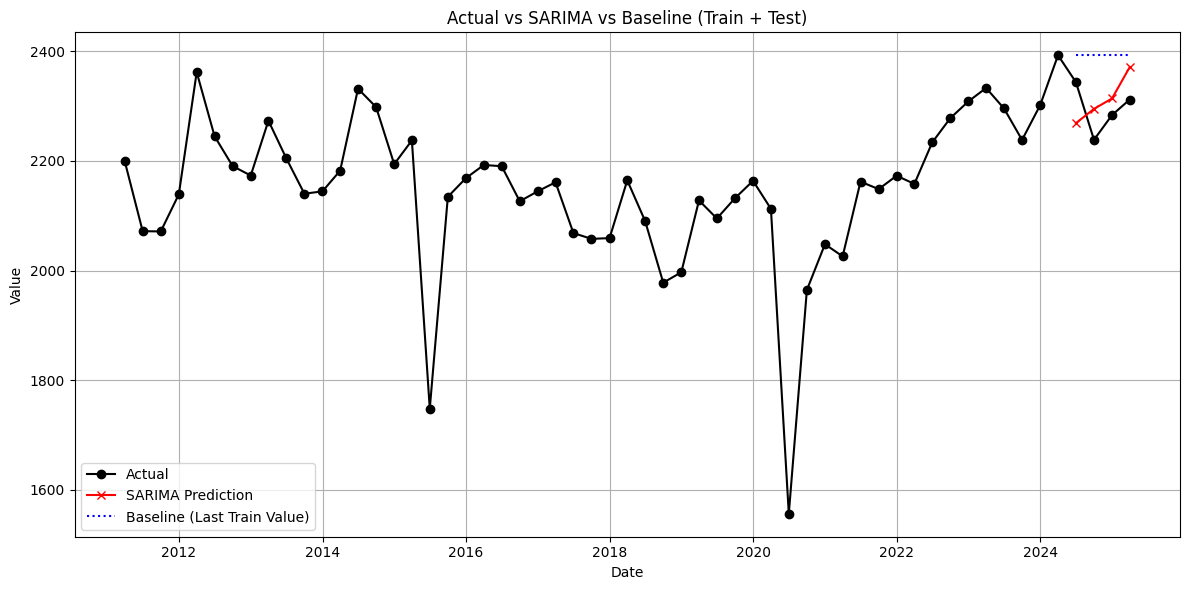

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime
train_full['date'] = pd.to_datetime(train_full['date'])
test['date'] = pd.to_datetime(test['date'])

# Get the last value of train for baseline
last_train_value = train_full['y'].iloc[-1]

# Create copies to avoid modifying original data
train_copy = train_full.copy()
test_copy = test.copy()

# Add predictions for clarity
test_copy['y_pred'] = test_copy['SARIMA_pred']
test_copy['baseline_pred'] = last_train_value
train_copy['SARIMA_pred'] = None
train_copy['baseline_pred'] = None

# Combine train and test for plotting
plot_df = pd.concat([train_copy, test_copy], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df['date'], plot_df['y'], label='Actual', color='black', marker='o')
plt.plot(test_copy['date'], test_copy['SARIMA_pred'], label='SARIMA Prediction', color='red', marker='x')
plt.plot(test_copy['date'], test_copy['baseline_pred'], label='Baseline (Last Train Value)', color='blue', linestyle=':')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs SARIMA vs Baseline (Train + Test)')
plt.legend()
plt.grid(True)

# NOTE: No ylim(bottom=0) here — Y-axis will auto-scale (zoomed)
plt.tight_layout()
plt.show()